In [0]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Data Import

In [0]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
data1 = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/1000ml/Unit2/Project5/intrusion_detection.csv')
data = pd.read_csv('/content/Drive/My Drive/Colab Notebooks/1000ml/Unit2/Project5/intrusion_detection_notonehot.csv')

In [0]:
print(f'Columns in intrusion_detection_notonehot.csv:  {data.shape[1]}')
print(f'Columns in intrusion_detection.csv:  {data1.shape[1]}')
print(f'Matching columns in both data sets:  {sum(data.columns.isin(data1.columns))}')

Columns in intrusion_detection_notonehot.csv:  44
Columns in intrusion_detection.csv:  82
Matching columns in both data sets:  40


#Data Cleaning

In [0]:
print(f'Amount of NaN-Values in the entire data set: {sum(data.isnull().sum())}')

Amount of NaN-Values in the entire data set: 0


In [0]:
data.dtypes.value_counts()

float64    38
object      4
int64       2
dtype: int64

#EDA

## Variable selection

* `num_outbounds_cmds`,`land`,`Unnamed: 0`, `id` are dropped
* We will select `outlier@{no,yes}` as the target variable

In [0]:
data.shape

(48113, 44)

In [0]:
data.nunique()

Unnamed: 0                     48113
duration                         238
src_bytes                       2375
dst_bytes                       9169
wrong_fragment                     3
urgent                             3
hot                               18
num_failed_logins                  3
logged_in                          2
num_compromissed                  18
root_shell                         2
su_attempted                       3
num_root                          15
num_file_creations                12
num_shells                         4
num_access_files                   5
num_outbounds_cmds                 1
is_host_login                      2
is_guest_login                     2
count                            335
srv_count                        341
serror_rate                       21
srv_serror_rate                   29
rerror_rate                        6
srv_rerror_rate                   32
same_srv_rate                     66
diff_srv_rate                     83
s

In [0]:
def n_counts_per(dataframe,unique_values = 1):
  for column in dataframe.columns[dataframe.nunique().values == unique_values]:
    print(dataframe[column].value_counts())
    print('----')

In [0]:
n_counts_per(data,1)

0.0    48113
Name: num_outbounds_cmds, dtype: int64
----
0    48113
Name: land, dtype: int64
----


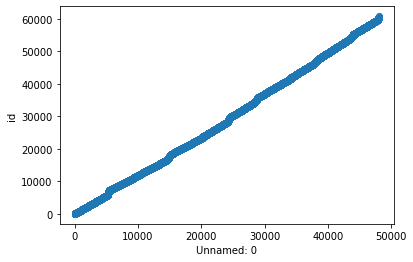

In [0]:
plt.scatter(data['Unnamed: 0'], data['id'])
plt.xlabel('Unnamed: 0')
plt.ylabel('id')
plt.show()

* `land` and `num_outbounds_cmds` only have one unique value. Therefore not very useful for our analysis.
* `Unnamed: 0` and `id` are just unique identifiers per record, that both increase in value. These aren't useful for classication either.

In [0]:
n_counts_per(data,2)

1.0    42475
0.0     5638
Name: logged_in, dtype: int64
----
0.0    48068
1.0       45
Name: root_shell, dtype: int64
----
0.0    48109
1.0        4
Name: is_host_login, dtype: int64
----
0.0    47993
1.0      120
Name: is_guest_login, dtype: int64
----
no     47913
yes      200
Name: outlier@{no,yes}, dtype: int64
----


* We will select `outlier@{no,yes}` as the target variable (and change (yes,no) to (1,0).

In [0]:
#drop columns with 1 unique value or all unique values
data = data.drop(columns= ['num_outbounds_cmds','land','Unnamed: 0', 'id'],axis=1)
#change (yes,no) in target variable to (1,0)
data['outlier@{no,yes}'] = np.where(data['outlier@{no,yes}'] == 'yes', 1, 0)
#slice numerical, categorical and target variables
cat_var = ['protocol_type','service','flag']
target = 'outlier@{no,yes}'
num_var = data.drop(columns= cat_var + [target], axis=1).columns.tolist()

## Exploration

### Categorical Variables

In [0]:
len(cat_var)

3

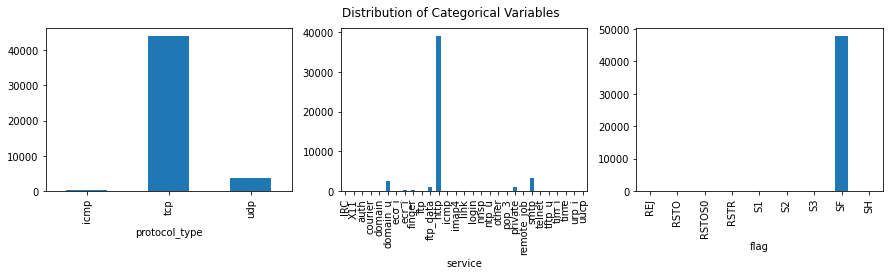

In [0]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):
  data[column].value_counts().sort_index().plot(kind='bar',ax=ax,rot=90)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

In [0]:
data['flag'].value_counts()

SF        47899
SH           80
REJ          49
RSTR         47
S1           17
S2           13
S3            4
RSTO          3
RSTOS0        1
Name: flag, dtype: int64

In [0]:
def freq_target_table(column):
  '''
  Gives the frequency of target values per categorical value of the column
  '''
  table=pd.crosstab(data[column],data[target])
  return table.div(table.sum(1).astype(float), axis=0)

In [0]:
freq_target_table('protocol_type')

"outlier@{no,yes}",0,1
protocol_type,,
icmp,0.835125,0.164875
tcp,0.996958,0.003042
udp,0.994723,0.005277


In [0]:
freq_target_table('flag')

"outlier@{no,yes}",0,1
flag,,
REJ,0.979592,0.020408
RSTO,0.666667,0.333333
RSTOS0,1.000000,0.000000
RSTR,1.000000,0.000000
S1,1.000000,0.000000
S2,1.000000,0.000000
S3,1.000000,0.000000
SF,0.997536,0.002464
SH,0.000000,1.000000


In [0]:
freq_target_table('service')

"outlier@{no,yes}",0,1
service,,
IRC,1.000000,0.000000
X11,1.000000,0.000000
auth,1.000000,0.000000
courier,0.000000,1.000000
domain,0.000000,1.000000
domain_u,1.000000,0.000000
eco_i,1.000000,0.000000
ecr_i,0.763314,0.236686
finger,1.000000,0.000000


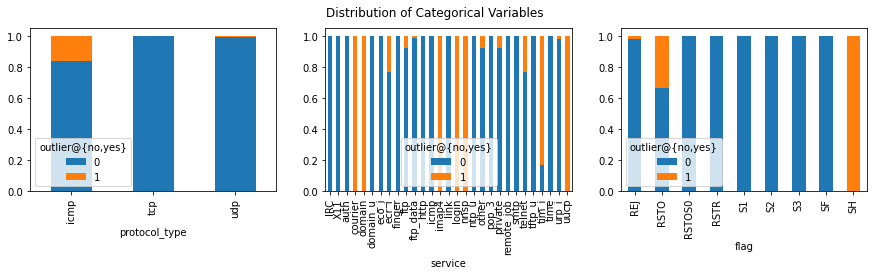

In [0]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):

  freq_target_table(column).plot(kind='bar', stacked=True,ax=ax)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

* We can group the values that have no harmful cases together, and reduce the amount of dummy variables needed for modeling.

* Based on the values that contain zero in the harm column of the frequency table, we group those categories together.

* We can also group the categories that are 100% harmful together

In [0]:
data['flag'] = np.where(data['flag'].isin(freq_target_table('flag')[freq_target_table('flag')[1]==0].index.tolist()),
                        'NoHarm',data['flag'])
data['service'] = np.where(data['service'].isin(freq_target_table('service')[freq_target_table('service')[1]==0].index.tolist()),
                        'NoHarm',data['service'])
data['service'] = np.where(data['service'].isin(freq_target_table('service')[freq_target_table('service')[1]==1].index.tolist()),
                        'Harm',data['service'])

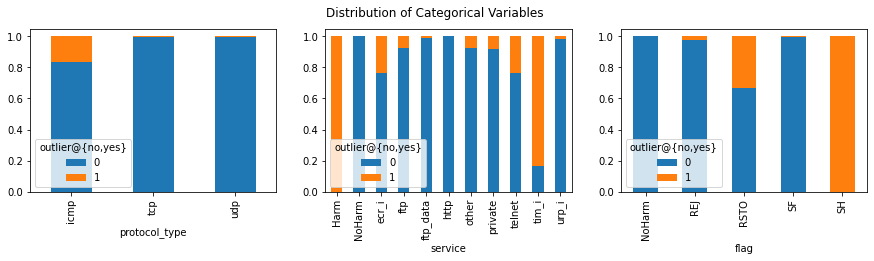

In [0]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):

  freq_target_table(column).plot(kind='bar', stacked=True,ax=ax)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

### Numerical Variables

* For some reason destroys the models performance

In [0]:
len(num_var)

36

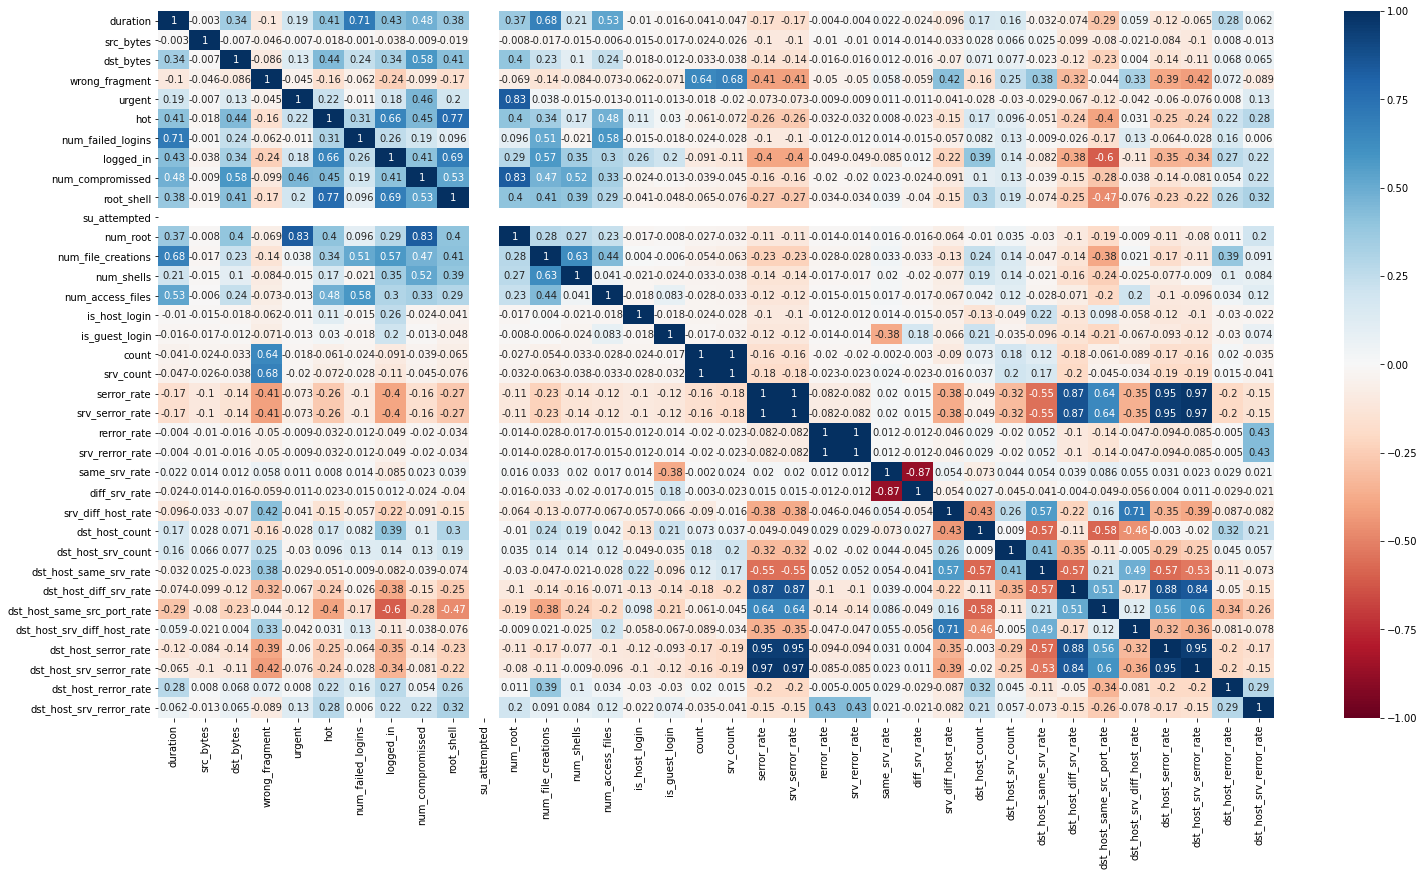

In [0]:
fig, ax = plt.subplots(1,1, figsize=(25,13))

sns.heatmap(data[num_var][data[target] == 1].corr().round(3), vmin=-1,vmax=1,cmap='RdBu',annot=True,ax=ax)

plt.show()

Since dealing with 36 numerical variables is a little excessive, we choose an absolute correlation > 0.8 within the hostile slice of the dataset as a cut off point for feature selection. 

We can therefore eliminate:
* `srv_count`, `srv_serror_rate`, `srv_rerror_rate`, `num_root`, `diff_srv_rate`, `dst_diff_host_srv_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate`

In [0]:
# remove_list = ['srv_count', 'srv_serror_rate', 'srv_rerror_rate',
#                'num_root', 'diff_srv_rate', 'dst_host_diff_srv_rate',
#                'dst_host_serror_rate', 'dst_host_srv_serror_rate']

# for item in remove_list:
#  num_var.remove(item)

In [0]:
len(num_var)

28

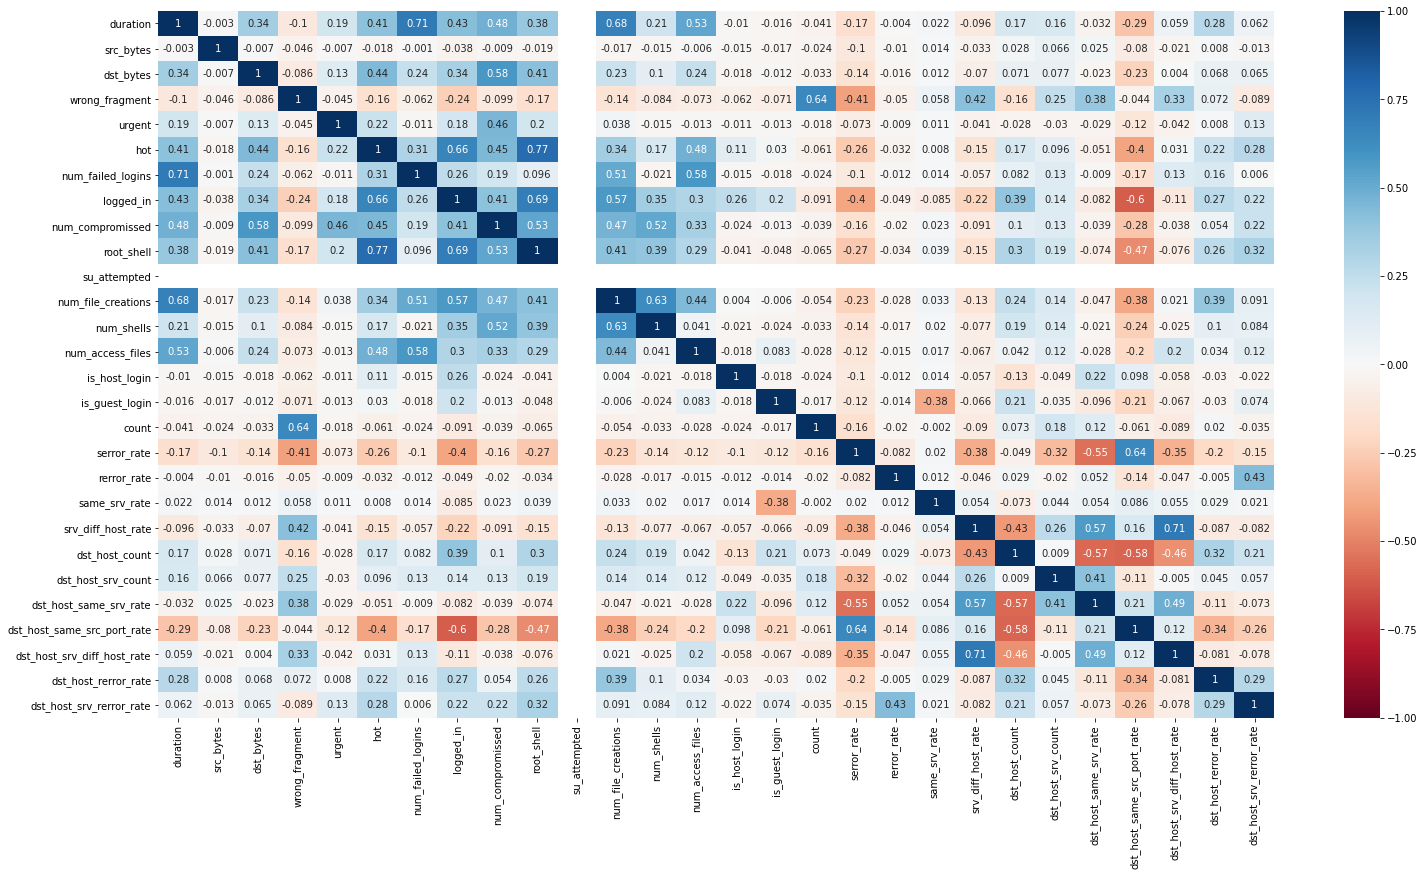

In [0]:
fig, ax = plt.subplots(1,1, figsize=(25,13))

sns.heatmap(data[num_var][data[target] == 1].corr().round(3), vmin=-1,vmax=1,cmap='RdBu',annot=True,ax=ax)

plt.show()

#Model

##Null Model (Simple Logistic Regression)
* Recall Score:
    * Train 0.40540540540540543
    * Validation 0.40384615384615385

In [0]:
len(num_var)

36

In [0]:
len(cat_var)

3

In [0]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 42)

#set the model
#clf stands for classifier
null = LogisticRegression(max_iter=1000)

#fit the model
null.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print(classification_report(y_train,null.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38342
           1       0.98      0.41      0.57       148

    accuracy                           1.00     38490
   macro avg       0.99      0.70      0.79     38490
weighted avg       1.00      1.00      1.00     38490



In [0]:
print(classification_report(y_val,null.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9571
           1       0.95      0.40      0.57        52

    accuracy                           1.00      9623
   macro avg       0.98      0.70      0.78      9623
weighted avg       1.00      1.00      1.00      9623



In [0]:
print(recall_score(y_train,null.predict(x_train)))
print(recall_score(y_val,null.predict(x_val)))

0.40540540540540543
0.40384615384615385


In [0]:
coef_df = pd.Series(null.coef_.round(3)[0],
          index = x.columns)

cutoff = 0.346

print(f'Amount of Variables left after cut-off at |{cutoff}|: {len(coef_df[abs(coef_df) > cutoff])}')
print('----')
print(coef_df[abs(coef_df) > cutoff])

Amount of Variables left after cut-off at |0.346|: 11
----
wrong_fragment              0.384
logged_in                  -0.407
same_srv_rate              -0.708
dst_host_same_srv_rate     -0.477
dst_host_serror_rate        0.381
dst_host_srv_serror_rate    0.350
protocol_type_tcp          -0.705
service_NoHarm             -0.933
service_private             0.367
flag_SF                    -1.066
flag_SH                     0.347
dtype: float64


In [0]:
var_null = coef_df[abs(coef_df) > cutoff].index.tolist()

## Logistic Regression
* Recall Score:
    * Train 0.9797297297297297
    * Validation 0.9807692307692307

* {'clf__C': 1e-06,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [0]:
# The 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is  
# only supported by the 'saga' solver. If 'none' (not supported by the  
# liblinear solver), no regularization is applied.  

# - 'newton-cg', 'lbfgs', 'sag' and 'saga' handle L2 or no penalty  
# - 'liblinear' and 'saga' also handle L1 penalty  
# - 'saga' also supports 'elasticnet' penalty  
# - 'liblinear' does not support setting `penalty='none'`

params_none = {'clf__penalty': ['none'],
               'clf__solver': ['lbfgs','newton-cg','sag','saga'],
               'clf__class_weight': ['balanced']}

params_l1 = {'clf__penalty': ['l1'],
             'clf__solver': ['liblinear','saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__class_weight': ['balanced']}           

params_l2 = {'clf__penalty': ['l2'],
             'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__class_weight': ['balanced']}

params_en = {'clf__penalty': ['elasticnet'],
             'clf__solver': ['saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__l1_ratio': np.arange(0,1,0.2),
             'clf__class_weight': ['balanced']}

In [0]:
params_none = {'clf__penalty': ['none'],
               'clf__solver': ['lbfgs'],
               'clf__class_weight': ['balanced']}

params_l1 = {'clf__penalty': ['l1'],
             'clf__solver': ['liblinear'],
             'clf__C': [0.01],
             'clf__class_weight': ['balanced']}          

params_l2 = {'clf__penalty': ['l2'],
             'clf__solver': ['liblinear'],
             'clf__C': [1e-06],
             'clf__class_weight': ['balanced']}

In [0]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x = x[var_null]
y = data[target]

#Train validation data split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)

# Set the parameters by cross-validation
super_params = [params_none, params_l1, params_l2]

#Make pipe, but change solver
pipe = Pipeline(steps = [('scaler', StandardScaler()), 
                        ('clf', LogisticRegression(random_state=42,max_iter=10000))])

clf_log = GridSearchCV(pipe, param_grid = super_params, scoring = 'recall',
                   cv=3, n_jobs = -1)

clf_log.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=10000,
                                                           multi_class='auto',
           

In [0]:
 clf_log.best_params_

{'clf__C': 1e-06,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [0]:
pd.DataFrame(clf_log.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,2,1,0
mean_fit_time,0.0615885,0.164891,0.277149
std_fit_time,0.0104971,0.0161505,0.0331429
mean_score_time,0.00949415,0.0104651,0.0103633
std_score_time,0.00160255,0.000338449,0.000745278
param_clf__class_weight,balanced,balanced,balanced
param_clf__penalty,l2,l1,none
param_clf__solver,liblinear,liblinear,lbfgs
param_clf__C,1e-06,0.01,NaN
params,"{'clf__C': 1e-06, 'clf__class_weight': 'balanc...","{'clf__C': 0.01, 'clf__class_weight': 'balance...","{'clf__class_weight': 'balanced', 'clf__penalt..."
split0_test_score,0.959184,0.938776,0.938776


In [0]:
print(recall_score(y_train,clf_log.predict(x_train)))
print(recall_score(y_val,clf_log.predict(x_val)))

0.9797297297297297
0.9807692307692307


In [0]:
print(classification_report(y_train,clf_log.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     38342
           1       0.02      0.98      0.05       148

    accuracy                           0.84     38490
   macro avg       0.51      0.91      0.48     38490
weighted avg       1.00      0.84      0.91     38490



In [0]:
print(classification_report(y_val,clf_log.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9571
           1       0.03      0.98      0.06        52

    accuracy                           0.84      9623
   macro avg       0.52      0.91      0.49      9623
weighted avg       0.99      0.84      0.91      9623



##KNN

* Recall Score:
    * Train 0.7702702702702703
    * Validation 0.7307692307692307

* {'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

In [0]:
#Setting the variables
x_knn = data[num_var]
x_knn = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x_knn = x[var_null]
y_knn = data[target]

#set numerical variables of model for transformation
numerical_variables = [item for item in num_var if item in var_null]

In [0]:
#train validation data split
x_knn_train, x_knn_val, y_knn_train, y_knn_val = train_test_split(x_knn,
                                                                  y_knn,
                                                                  test_size = 0.2,
                                                                  random_state = 42)

In [0]:
#set Transformer
knn_transformer = ColumnTransformer(transformers =
                                    [('scaler', MinMaxScaler(), numerical_variables)],
                                    remainder = 'passthrough',
                                    verbose = True)

In [0]:
#make pipeline with column transformer and KNN
knn_pipe = Pipeline(steps= [('transform', knn_transformer),
                            ('knn',KNeighborsClassifier())],
                    verbose=True)

In [0]:
params = {'knn__n_neighbors': np.arange(4,16,2),
            'knn__weights': ['uniform','distance'],
            'knn__p': [1,2]}

In [0]:
#Set grid search
clf_knn = GridSearchCV(knn_pipe,
                            params, 
                            scoring = 'recall', 
                            cv = 3, 
                            n_jobs = -1, 
                            verbose = 1,
                            return_train_score = True)

In [0]:
clf_knn.fit(x_knn, y_knn)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 33.1min finished


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   4.2s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['wrong_fragment',
                                                                  

In [0]:
clf_knn.best_params_

{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}

In [0]:
pd.DataFrame(clf_knn.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,21,23,1,3,5,13,7,9,11,15,17,19,0,2,4,8,16,20,10,6,12,18,22,14
mean_fit_time,3.16013,3.10392,2.84635,3.12053,3.08036,2.76677,3.00982,2.79104,3.15134,3.08341,3.15853,2.88861,3.28058,3.10343,3.32295,3.12805,3.32918,2.99736,3.20681,3.20676,3.40563,3.34965,3.39963,2.74454
std_fit_time,0.460837,0.289683,0.161674,0.474239,0.260436,0.0378481,0.194929,0.144364,0.364906,0.432604,0.438564,0.114711,0.347437,0.38517,0.317344,0.287504,0.477522,0.21614,0.250018,0.241672,0.269243,0.238929,0.37169,0.138431
mean_score_time,17.7067,16.2809,17.2702,16.476,17.3802,17.223,16.2635,17.5587,16.3208,16.3704,17.4861,16.4012,17.9533,17.0258,18.1446,18.0837,18.122,18.1665,16.8174,16.8954,18.0109,16.9939,17.2026,16.8128
std_score_time,0.0580765,0.0707774,0.0442617,0.157047,0.060771,0.0535639,0.0534133,0.113501,0.0726363,0.0157672,0.12786,0.0493004,0.0975334,0.0663202,0.16368,0.0387199,0.100231,0.1053,0.0756322,0.0851743,0.0926875,0.0497663,0.312293,0.132706
param_knn__n_neighbors,14,14,4,4,6,10,6,8,8,10,12,12,4,4,6,8,12,14,8,6,10,12,14,10
param_knn__p,1,2,1,2,1,1,2,1,2,2,1,2,1,2,1,1,1,1,2,2,1,2,2,2
param_knn__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
params,"{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 4, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 6, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 4, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 8, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__we..."
split0_test_score,0.567164,0.567164,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.268657,0.268657,0.238806,0.238806,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955
split1_test_score,0.507463,0.507463,0.61194,0.537313,0.552239,0.567164,0.537313,0.537313,0.537313,0.537313,0.507463,0.507463,0.462687,0.462687,0.492537,0.477612,0.462687,0.462687,0.477612,0.477612,0.477612,0.462687,0.462687,0.462687


In [0]:
print(recall_score(y_train,clf_knn.predict(x_train)))
print(recall_score(y_val,clf_knn.predict(x_val)))

0.7702702702702703
0.7307692307692307


In [0]:
print(classification_report(y_train,clf_knn.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38342
           1       0.91      0.77      0.84       148

    accuracy                           1.00     38490
   macro avg       0.96      0.88      0.92     38490
weighted avg       1.00      1.00      1.00     38490



In [0]:
print(classification_report(y_val,clf_knn.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9571
           1       0.93      0.73      0.82        52

    accuracy                           1.00      9623
   macro avg       0.96      0.87      0.91      9623
weighted avg       1.00      1.00      1.00      9623



##Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier 